# Env: qiskit-env

In [ ]:
import numpy as np
import scipy.linalg as la
from scipy.optimize import minimize
import math
import random

from scipy.sparse import csr_matrix


import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler, Estimator
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.primitives import BackendSampler

from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, OptionsV2

In [ ]:
N = 5
n = N - 1
L = 10.0
dx = L / N
D = 1.0
xs_a = 0.1
S = 1.0 


def diffusion_matrix(D, xs_a): #finite difference
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2 * D / dx**2 + xs_a
        if i > 0:
            A[i, i - 1] = -D / dx**2
        if i < n - 1:
            A[i, i + 1] = -D / dx**2
    return A

A = diffusion_matrix(D, xs_a)
b = np.full(n, S * dx)
b_norm = b / np.linalg.norm(b)

classical_solution = la.solve(A, b_norm)
ref_solution = classical_solution / np.linalg.norm(classical_solution)
print("Classical solution:", classical_solution)
print("Reference solution:", ref_solution)
print("A", A)

Classical solution: [0.93901142 1.55746451 1.93171149 2.10795571 2.10795571 1.93171149
 1.55746451 0.93901142]
Reference solution: [0.1959472  0.32500224 0.40309783 0.43987541 0.43987541 0.40309783
 0.32500224 0.1959472 ]
A [[ 1.72 -0.81  0.    0.    0.    0.    0.    0.  ]
 [-0.81  1.72 -0.81  0.    0.    0.    0.    0.  ]
 [ 0.   -0.81  1.72 -0.81  0.    0.    0.    0.  ]
 [ 0.    0.   -0.81  1.72 -0.81  0.    0.    0.  ]
 [ 0.    0.    0.   -0.81  1.72 -0.81  0.    0.  ]
 [ 0.    0.    0.    0.   -0.81  1.72 -0.81  0.  ]
 [ 0.    0.    0.    0.    0.   -0.81  1.72 -0.81]
 [ 0.    0.    0.    0.    0.    0.   -0.81  1.72]]


In [ ]:
n_qubits = int(np.ceil(np.log2(n)))
dim = 2**n_qubits
#backend = AerSimulator()
sampler = Sampler()
estimator = Estimator()
shots = 4096

state_prep = EfficientSU2(num_qubits=2, entanglement='linear', reps=1)


backend_name = "ibm_brisbane"
backend_real = QiskitRuntimeService().backend(backend_name)

service = QiskitRuntimeService(name = "melekderman")
backend_real = service.backend(name = "ibm_brisbane")

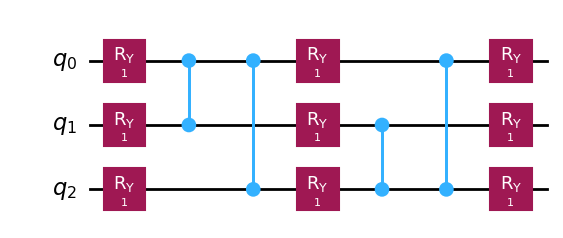

In [4]:
# from ref #10
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

In [5]:
# from ref #10
# Creates the Hadamard test

def had_test(circ, gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)

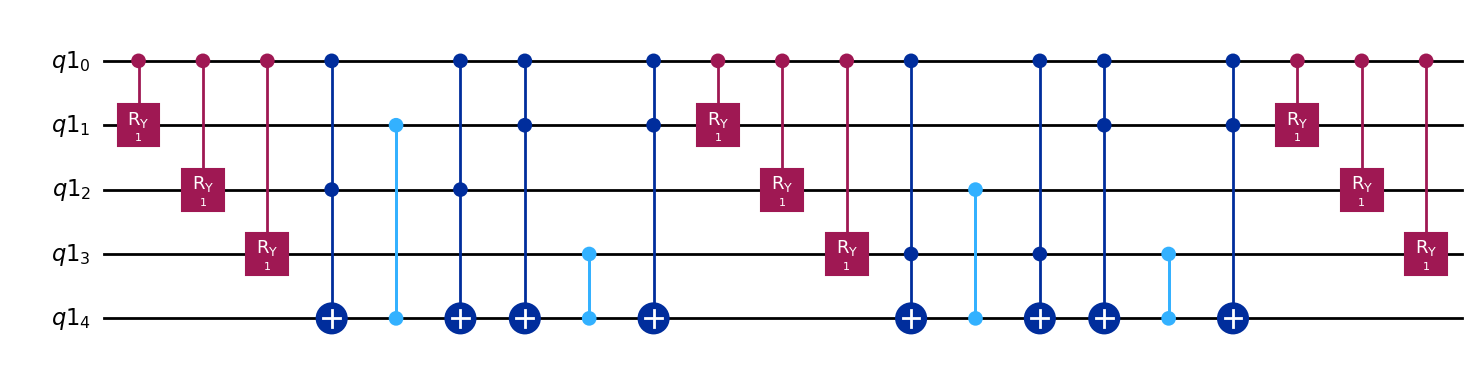

In [6]:
# from ref #10
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw('mpl')


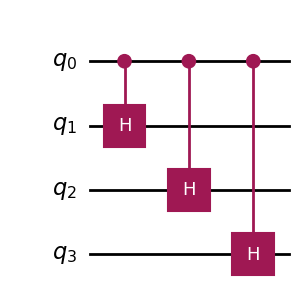

In [7]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw('mpl')

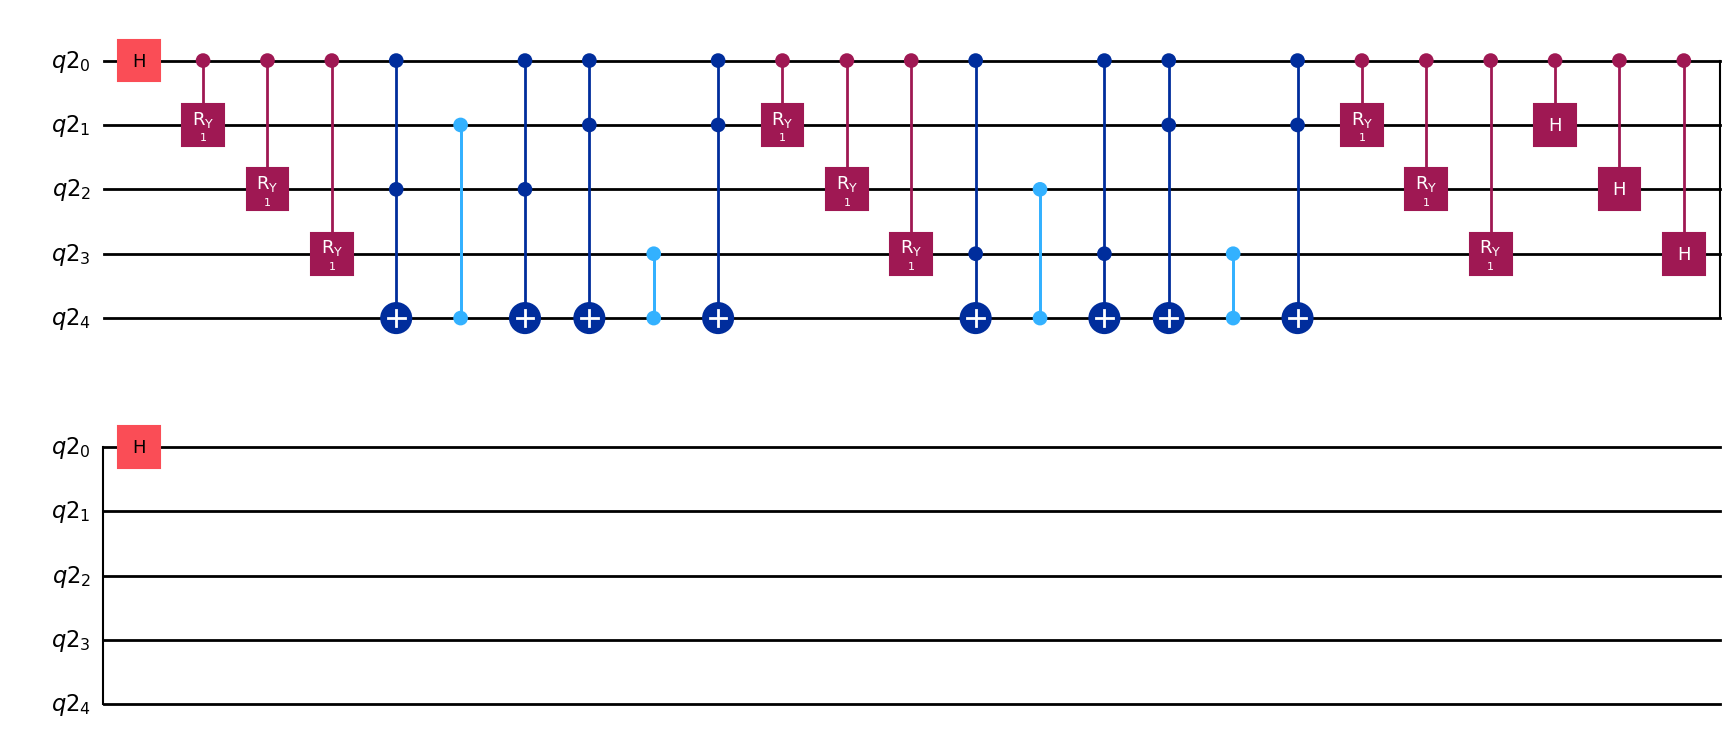

In [8]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(circ, gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test(circ, [[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw('mpl')

In [9]:
# Implements the entire cost function on the quantum circuit

def calculate_cost_function(x):
    
    global opt

    overall_sum_1 = 0
    parameters = x.reshape((3, n_qubits))
    #parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i, G1 in enumerate(gate_set):
        for j, G2 in enumerate(gate_set):

            global circ

            qctl = QuantumRegister(n_qubits+1)
            qc = ClassicalRegister(n_qubits+1)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('aer_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test(
                circ,
                [G1, G2],
                list(range(1, n_qubits+1)),
                0,
                parameters
            )

            circ.save_statevector()
            t_circ = transpile(circ, backend)
            job = backend.run(t_circ)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                if (extra == 0):
                    special_had_test(circ, gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(circ, gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.save_statevector()    
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ)
    
                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [10]:
# Prepare the quantum circuit
n_qubits = int(np.ceil(np.log2(len(b_norm))))       # number of qubits
print(f"Using {n_qubits} qubit(s) to encode {len(b_norm)} amplitude.")

# Aer simulator backend
noise_model = NoiseModel.from_backend(backend_real)
backend = AerSimulator(method='automatic', noise_model=noise_model)

# |b> state preparation
qc_b = QuantumCircuit(n_qubits)                     
qc_b.initialize(b_norm, list(range(n_qubits)))

# Convert A matrix to SparsePauliOp
A_op = SparsePauliOp.from_operator(A)
pauli_labels  = A_op.paulis.to_labels()
pauli_coeffs  = A_op.coeffs

gate_set        = []
coefficient_set = []
for lbl, c in zip(pauli_labels, pauli_coeffs):
    mask = [1 if p!='I' else 0 for p in lbl]
    gate_set.append(mask)
    coefficient_set.append(np.real(c))

x0 = [random.random() * np.pi for _ in range(3*n_qubits)]
res = minimize(calculate_cost_function,
               x0=x0,
               method="COBYLA",
               options={'maxiter':20})
opt_params = res.x.reshape((3, n_qubits))
    


Using 3 qubit(s) to encode 8 amplitude.
0.9827432641016286
0.9892945005390954
0.9090657778410574
0.854030599298788
0.9386889470043587
0.7985189202992661
0.8098207252339455
0.7065928267293253
0.6196872259510702
0.7009975579334428
0.5818171525409224
0.6071921015567472
0.6188726482180626
0.6448818935944403
0.5549999696885677
0.3743571507174306
0.39447422492666684
0.36241863979854727
0.6601225737056728
0.38322517851695437


In [11]:
coefficient_set = [1.72, -0.81, -0.405, -0.405, -0.2025]
gate_set = [
 [0, 0, 0],   # I ⊗ I ⊗ I
 [0, 0, 1],   # I ⊗ I ⊗ X
 [0, 1, 1],   # I ⊗ X ⊗ X
 [0, 2, 2],   # I ⊗ Y ⊗ Y
 [1, 1, 1]    # X ⊗ X ⊗ X
]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')

t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

pauli_map = {
    0: np.array([[1, 0], [0, 1]]),   # I
    1: np.array([[0, 1], [1, 0]]),   # X
    2: np.array([[0, -1j], [1j, 0]]),# Y
    3: np.array([[1, 0], [0, -1]])   # Z
}

A = np.zeros((8, 8), dtype=complex)
for coeff, gate in zip(coefficient_set, gate_set):
    term = pauli_map[gate[0]]
    for g in gate[1:]:
        term = np.kron(term, pauli_map[g])
    A += coeff * term

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(A.dot(o) / np.linalg.norm(A.dot(o))))**2)


0.982784100207988
0.8445352217546207
0.6290944148293518
0.7966415275056706
0.4288576193281629
0.43837539710285156
0.6026095516314584
0.3876700211896902
0.652298463182321
0.567753617721168
0.39638647804771554
0.5250681561510155
0.4051963776927776
0.3204635717445794
0.32881078699028776
0.32109164134548696
0.34821933903719227
0.3231950932542663
0.44756024854470366
0.3822311113575634
0.3938738977703864
0.39966601428980286
0.3200918756292762
0.30432005651966165
0.29149793040322713
0.2743743232388831
0.3178900679482448
0.2765784376240932
0.2813710725563192
0.271366797989672
0.2704827335959946
0.28087260835863626
0.2726576242205879
0.2737996231304817
0.2854899992772907
0.2611428947473755
0.2733976939669881
0.26061561339152983
0.2517257236139204
0.24991257195334615
0.24998066748421666
0.24688271568543851
0.24793007550648716
0.2430211227604504
0.24248279481964652
0.2431021709707032
0.24032714085574147
0.2612423418283023
0.23956786867319302
0.24159339485229736
0.2434384552493415
0.24024695588484

NameError: name 'assemble' is not defined

In [12]:
coefficient_set = [1.72, -0.81, -0.405, -0.405, -0.2025]
gate_set = [
 [0, 0, 0],   # I ⊗ I ⊗ I
 [0, 0, 1],   # I ⊗ I ⊗ X
 [0, 1, 1],   # I ⊗ X ⊗ X
 [0, 2, 2],   # I ⊗ Y ⊗ Y
 [1, 1, 1]    # X ⊗ X ⊗ X
]

x0 = [random.uniform(0, 2*np.pi) for _ in range(9)]
out = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')

t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

pauli_map = {
    0: np.array([[1, 0], [0, 1]]),   # I
    1: np.array([[0, 1], [1, 0]]),   # X
    2: np.array([[0, -1j], [1j, 0]]),# Y
    3: np.array([[1, 0], [0, -1]])   # Z
}

A = np.zeros((8, 8), dtype=complex)
for coeff, gate in zip(coefficient_set, gate_set):
    term = pauli_map[gate[0]]
    for g in gate[1:]:
        term = np.kron(term, pauli_map[g])
    A += coeff * term

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(A.dot(o) / np.linalg.norm(A.dot(o))))**2)


0.9628140639791604
0.9999292205960596
0.9488530866693621
0.9519284600611544
0.9334296646477345
0.9271696281621742
0.9389363237824421
0.9912754921551682
0.8656664208030276
0.9981631178882803
0.7308732174315598
0.5843546928289461
0.4413163144168508
0.3991288878332435
0.6747680718832471
0.5057859841235092
0.447472901498829
0.5522178885170399
0.30235509729383536
0.4019122965447731
0.2895004842113168
0.6499630075622673
0.28611584676304835
0.5592408201962003
0.2327549030840319
0.28814331855462827
0.35211121859006056
0.24493935649324516
0.2729036708228888
0.23079228467258228
0.2851982418887601
0.281792092545016
0.29985023665801425
0.22067893174098385
0.22130907009623135
0.24087251728639603
0.22628758325155085
0.27304295209462204
0.23247485140947255
0.23874998941204106
0.22012722468611312
0.22308911930640207
0.2171269710605146
0.21811468172958703
0.2168147078290552
0.22174088827660232
0.2142064821382328
0.21954068073574073
0.21780960848094666
0.22495319265189995
0.21732627356097634
0.216109182

NameError: name 'assemble' is not defined